In [1]:
import numpy as np
from data import data_video, data_deeplabcut, dataset_opto
from utils import utils
import analysis
import measures
import partial_procrustes_superimposition as pps
import SSM
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.cm as cm
import pickle
import seaborn as sb
import project

sb.set()

# from importlib import reload  
# reload(analysis_storchi.measures)

## Load project

In [2]:
project_path = r'E:\dlc\OpenfieldOpto'
cfg = project.load_project(project_path)
analysis_path = os.path.join(project_path, 'analysis')

In [3]:
dataset = dataset_opto.DatasetOpto(cfg=cfg)

In [4]:
# trial time window after stimulation
time_window = 90


# Data analysis

In [5]:
# Transform dict of dicts into 1 large dataframe / dataframes per mouseline (or numpy matrices)
def flatten_dict_all(df_dict, mode='npy'):
    df_all = []
    start_idx = 0
    dict_meta = {line: {} for line in df_dict.keys()}
    for line, df_dict_line in df_dict.items():
        for (exp, sess), df in df_dict_line.items():
            df_all.append(df)
            stop_idx = start_idx+len(df)
            dict_meta[line][(exp, sess)] = (start_idx, stop_idx)
            start_idx = stop_idx
    if mode=='pandas':
        return pd.concat(df_all, axis=0), dict_meta
    else:
        return np.concatenate(df_all, axis=0), dict_meta
    
def flatten_dict_line(df_dict, mode='npy'):
    df_dict_flat = {line: [] for line in df_dict.keys()} 
    dict_meta = {line: {} for line in df_dict.keys()}
    for line, df_dict_line in df_dict.items():
        start_idx = 0
        for (exp, sess), df in df_dict_line.items():
            df_dict_flat[line].append(df)
            stop_idx = start_idx+len(df)
            dict_meta[line][(exp, sess)] = (start_idx, stop_idx)
            start_idx = stop_idx
    if mode=='pandas':
        df_dict_flat = {line: pd.concat(df_list, axis=0) for line, df_list in df_dict_flat.items()}
        return df_dict_flat, dict_meta
    else:
        df_dict_flat = {line: np.concatenate(df_list, axis=0) for line, df_list in df_dict_flat.items()}
        return df_dict_flat, dict_meta

def inverse_flatten_dict_all(df_combined, df_dict_meta, mode='npy'):
    df_dict = {line: {} for line in df_dict_meta.keys()}
    for line, df_dict_line in df_dict_meta.items():
        for (exp, sess), (start_idx, stop_idx) in df_dict_line.items():
            if mode == 'pandas':
                df_dict[line][(exp, sess)] = df_combined.iloc[start_idx:stop_idx]
            else:
                df_dict[line][(exp, sess)] = df_combined[start_idx:stop_idx]
    return df_dict

# Normalize all
def normalize_combined(df_dict, method='quantiles', n_intervals=10000, n_minmax=100):
    df_flat, df_flat_meta = flatten_dict_all(df_dict, mode='pandas')
    df_flat = df_flat.reset_index()
    if method == 'quantiles':
        df_flat_norm = measures.normalize_quantiles(df_flat, n_intervals=n_intervals)
        df_flat_norm = df_flat_norm.set_index('index')
    elif method == 'zscore':
        df_flat_norm, _, _ = measures.normalize_zscore(df_flat)
    elif method == 'minmax':
        df_flat_norm = measures.normalize_scaling(df_flat, n=n_minmax)

    return inverse_flatten_dict_all(df_flat_norm, df_flat_meta)


def normalize_trials(df_dict_trials, time_window, method='quantiles', n_intervals=10000, n_minmax=100):
    # Concatenate trials
    def _conc(df, meta):
        return pd.concat(df)
    new_dict = apply_dict_fn(df_dict_trials, _conc)
    
    # Normalize
    new_dict_norm = normalize_combined(new_dict, method, n_intervals, n_minmax)
        
    # Resplit trials
    def _split(df, meta):
        trials = []
        for i in range(0, len(df), time_window):
            trials.append(df.iloc[i:i+time_window])
        return trials
    new_dict = apply_dict_fn(new_dict_norm, _split)
    return new_dict


def apply_dict_fn(df_dict, fn, **args):
    """ Applies the given function to each session data in the dict. """
    new_dict = {line: {} for line in df_dict.keys()}
    for line, df_dict_line in df_dict.items():
        for (exp, sess), df in df_dict_line.items():
            new_dict[line][(exp, sess)] = fn(df, (line, exp, sess), **args)
    return new_dict


def split_trials(df_dict, stim_dict, time_window=150):
    df_dict_trials = {line: {} for line in df_dict.keys()}
    for line, df_dict_line in df_dict.items():
        for (exp, sess), df in df_dict_line.items():
            trials = []
            stim_times = stim_dict[line][(exp, sess)]
            for stim_start, stim_end in stim_times:
                trials.append(df.iloc[stim_start:stim_start+time_window])
            df_dict_trials[line][(exp, sess)] = trials
    return df_dict_trials


In [6]:
# get all sessions and trial times
df_dict, stim_dict, offset_dict = dataset.get_all_sessions() 
# Smooth measures
def _smooth_df(df, meta):
    df = df.copy()
    for measure in df['measures'].columns:
        df['measures', measure] = df['measures', measure].rolling(window=3, center=True).median()
    return df

df_dict = apply_dict_fn(df_dict, _smooth_df)

No valid session found for exp 989.0, sess 1.0, line CONTROL.
No valid session found for exp 1077.0, sess 1.0, line PV.
No valid session found for exp 1104.0, sess 1.0, line PV.
No valid session found for exp 1107.0, sess 1.0, line GAD2.
No valid session found for exp 1165.0, sess 1.0, line PV.
No valid session found for exp 1166.0, sess 1.0, line PV.
No valid session found for exp 1249.0, sess 1.0, line CONTROL.
No valid session found for exp 1252.0, sess 1.0, line CONTROL.
No valid session found for exp 1314.0, sess 1.0, line CAMKII.
No valid session found for exp 1315.0, sess 1.0, line CAMKII.
No valid session found for exp 1316.0, sess 1.0, line CAMKII.
No valid session found for exp 1317.0, sess 1.0, line CAMKII.


In [7]:
df_dict_norm = normalize_combined(df_dict)

post_elongation
post_bend
post_bend_D
mov_locomotion
mov_acceleration
mov_freeze
mov_rotation
mov_rotation_D
mov_elongation
mov_bend
mov_bend_D
mov_locomotion_side_angle
mov_locomotion_side_dist
corner_distance


In [8]:
""" Split in trials (df_dict_norm, stim_dict) """
df_dict_trials0 = split_trials(df_dict, stim_dict, time_window)
df_dict_trials_norm0 = split_trials(df_dict_norm, stim_dict, time_window)

# Up till here, we still have all information in each trial

In [9]:
""" Add lateral distance relative to start of trial to all trial data. """
def mov_locomotion_side_trial(df):
    trial = df.copy()
    orient_vector = trial.iloc[0]['nose'][['x', 'y']] - trial.iloc[0]['tail_start'][['x', 'y']]
    angles = -trial.iloc[0]['R'][0]
#     print(angles)
    rot_matrix = np.array([[np.cos(angles), -np.sin(angles)], [np.sin(angles), np.cos(angles)]])

    orient_vector_R = orient_vector @ rot_matrix.T
    start_pos = trial.iloc[0][['T_x', 'T_y']]
    transl_vectors = trial[['T_x', 'T_y']] - start_pos
#     transl_vectors = trial[['T_x', 'T_y']].diff().reset_index(drop=True)
    transl_vectors = transl_vectors.droplevel(level=1, axis=1)

    dot = orient_vector_R[0] * transl_vectors['T_x'] + orient_vector_R[1] * transl_vectors['T_y']
    det = orient_vector_R[0] * transl_vectors['T_y'] - orient_vector_R[1] * transl_vectors['T_x']
    angle = np.arctan2(det, dot)

    transl_vectors = transl_vectors.rename(columns={"T_x": "x", "T_y": "y"})
    tiled_orient_vector_R = np.tile(orient_vector_R, (len(transl_vectors),1))
#     print(tiled_orient_vector_R.shape)
    orth_proj = np.multiply(tiled_orient_vector_R, dot[:, np.newaxis]) / orient_vector_R.dot(orient_vector_R)
    lateral_distance = np.linalg.norm(transl_vectors - orth_proj, axis=1)
    lateral_distance = lateral_distance * np.sign(angle) * -1
    trial['measures', 'lateral_distance'] = lateral_distance
    return trial

lateral_distances_all = []
df_dict_trials = {line: {} for line in df_dict_trials0.keys()}
for line, df_dict_line in df_dict_trials0.items():
    for (exp, sess), trials in df_dict_line.items():
        new_trials = []
        for trial in trials:
            new_trial = mov_locomotion_side_trial(trial)
            lateral_distances_all.append(new_trial['measures', 'lateral_distance'])
            new_trials.append(new_trial)
        df_dict_trials[line][exp, sess] = new_trials

# NORMALIZE LATERAL_DISTANCE RESPONSES

ld_df = pd.concat(lateral_distances_all)
n_intervals=999
intervals = np.linspace(0, 1, num=n_intervals)
values = np.squeeze(np.repeat(intervals[:, None], np.ceil(len(ld_df) / n_intervals), axis=0))[:len(ld_df)]
ld_df = ld_df.reset_index(drop=True)
ld_df = ld_df.sort_values()
idxs = ld_df.index
ld_df.update(pd.Series(values, index=idxs))
ld_df = ld_df.sort_index()
print("Max:", np.max(ld_df), ", Min:", np.min(ld_df))
curr_idx = 0
df_dict_trials_norm = {line: {} for line in df_dict_trials_norm0.keys()}
for line, df_dict_line in df_dict_trials_norm0.items():
    for (exp, sess), trials in df_dict_line.items():
        new_trials = []
        for trial in trials:
            new_trial = trial.copy()
            new_trial['measures', 'lateral_distance'] = ld_df.iloc[curr_idx:curr_idx+len(trial)].to_numpy()
            curr_idx += len(trial)
            new_trials.append(new_trial)
#             new_trials.append(mov_locomotion_side_trial(trial))
        df_dict_trials_norm[line][exp, sess] = new_trials

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


Max: 0.9629258517034067 , Min: 0.0


In [10]:
""" Uncomment if you want to normalize using only the trials!! """
df_dict_trials_norm =  normalize_trials(df_dict_trials, time_window, method='quantiles') # zscore, minmax

post_elongation
post_bend
post_bend_D
mov_locomotion
mov_acceleration
mov_freeze
mov_rotation
mov_rotation_D
mov_elongation
mov_bend
mov_bend_D
mov_locomotion_side_angle
mov_locomotion_side_dist
corner_distance
lateral_distance


In [11]:
# np.min(df_dict_trials0['PV'][863,1][0]['measures', 'mov_rotation'])
# df_dict_trials0['PV'].keys()
tmp_dict = flatten_dict_all(df_dict, mode='pandas')[0]
print(tmp_dict['measures', 'mov_rotation_D'].describe())

count    1.333863e+06
mean    -4.453370e-03
std      5.242850e-02
min     -2.996212e+00
25%     -2.572697e-02
50%     -1.608588e-03
75%      1.750760e-02
max      2.991172e+00
Name: (measures, mov_rotation_D), dtype: float64


# Visualize measures data

In [12]:
measures_labels = ['Elon', 'Bend', 'Bend_dir', 'Loc', 'Acc', 'Fre', 'dRot', 'dRot_dir', 'dElon', 'dBend', 'dBend_dir', 'SideLoc_angle', 'SideLoc_dist', 'Corner_dist', 'lateral_distance']
measures_list = df_dict_trials['CAMKII'][(714,1)][0]['measures'].columns

num_measures = len(measures_list)


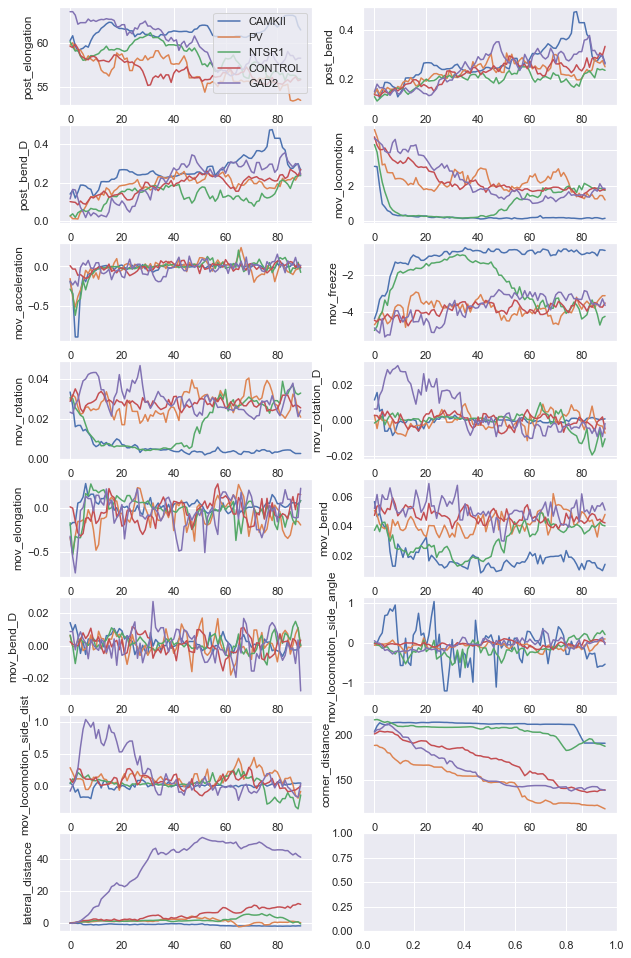

In [13]:
""" Lineplots for all measures. NOT NORMALIZED"""
fig, axs = plt.subplots(int(np.ceil(num_measures/2)), 2, figsize=(10, 17))

measures_to_visualize = []
for line, df_dict_line in df_dict_trials.items():
    measures_data= {}
    for (exp, sess), trials in df_dict_line.items():
        for trial in trials:
            for measure in trial['measures']:
                if measure not in measures_data:
                    measures_data[measure] = []
                measures_data[measure].append(trial['measures', measure])
                
    timepoints = np.tile(np.arange(0, time_window, 1), (len(measures_data['mov_rotation'])))
    for i, (measure, measure_data) in enumerate(measures_data.items()):
        data = np.concatenate(measure_data)
        if i == 0:
            sb.lineplot(x=timepoints, y=data, dashes=None, ax=axs[i//2,i%2], label=line, ci=None, estimator='median')
        else:
#             axs[i//2,i%2].plot(measure_data, c='gray', alpha=0.1)
            sb.lineplot(x=timepoints, y=data, dashes=None, ax=axs[i//2,i%2], ci=None, estimator='median')
        axs[i//2,i%2].set(ylabel=measure)

axs[0,0].legend(loc='upper right')

# plt.ylim(0, 1)
plt.savefig(os.path.join(analysis_path, 'measures_lineplots.png'), dpi=150)
plt.show()

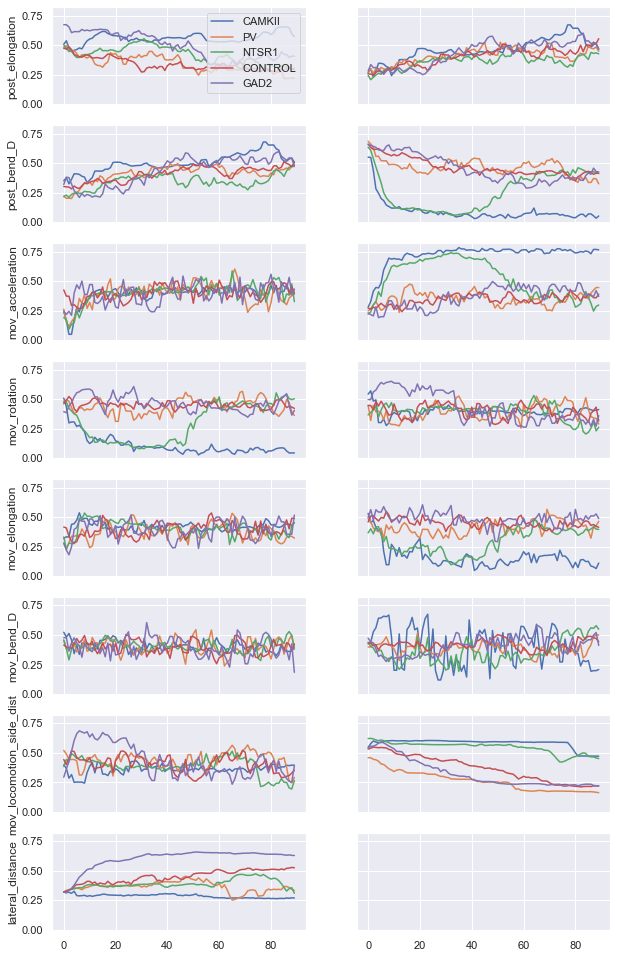

In [14]:
""" Lineplots for all measures. NORMALIZED """
fig, axs = plt.subplots(int(np.ceil(num_measures/2)), 2, figsize=(10, 17), sharey=True, sharex=True)

measures_to_visualize = []
for line, df_dict_line in df_dict_trials_norm.items():
    measures_data= {}
    for (exp, sess), trials in df_dict_line.items():
        for trial in trials:
            for measure in trial['measures']:
                if measure not in measures_data:
                    measures_data[measure] = []
                measures_data[measure].append(trial['measures', measure])
                
    timepoints = np.tile(np.arange(0, time_window, 1), (len(measures_data['mov_rotation'])))
    for i, (measure, measure_data) in enumerate(measures_data.items()):
        data = np.concatenate(measure_data)
        if i == 0:
#             axs[i//2,i%2].plot(measure_data, c='gray', alpha=0.1)
            sb.lineplot(x=timepoints, y=data, dashes=None, ax=axs[i//2,i%2], label=line, ci=None, estimator='median')
        else:
#             axs[i//2,i%2].plot(measure_data, c='gray', alpha=0.1)
            sb.lineplot(x=timepoints, y=data, dashes=None, ax=axs[i//2,i%2], ci=None, estimator='median')
        axs[i//2,i%2].set(ylabel=measure)

axs[0,0].legend(loc='upper right')

plt.savefig(os.path.join(analysis_path, 'measures_lineplots_normalized.png'), dpi=150)

plt.show()

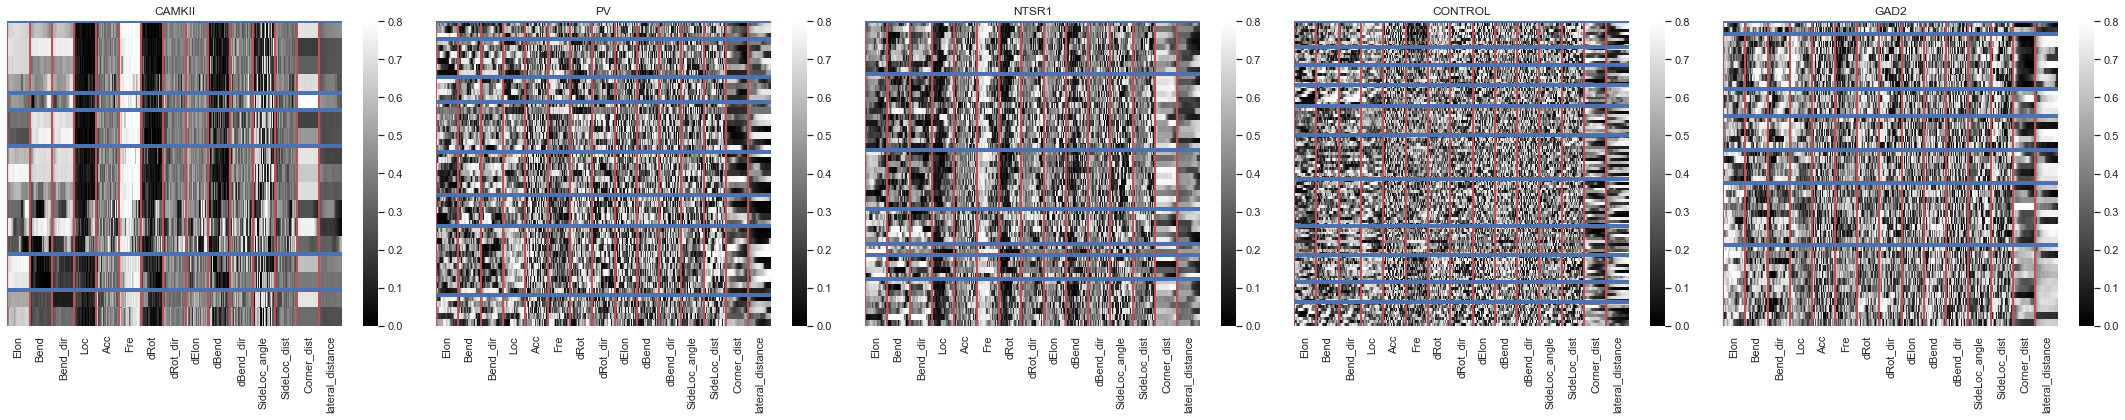

In [15]:
""" Heatmaps for each mouseline. """
# Only used for visualization of 
def _flatten_trials(trials, meta, n=150, measures=None):
    heatmap = []
    for trial in trials:
        if measures is not None:
            heatmap.append(utils.split_data_segments(trial['measures'][measures].to_numpy(), n=n))
        else:
            heatmap.append(utils.split_data_segments(trial['measures'].to_numpy(), n=n)) # Make it reorganize in the correct way!!
    return np.concatenate(heatmap, axis=0)
df_dict_trials_flat = apply_dict_fn(df_dict_trials_norm, _flatten_trials, n=time_window)
trials_heatmap, trials_heatmap_meta = flatten_dict_line(df_dict_trials_flat)

fig, axs = plt.subplots(1, 5, figsize=(30, 6))
for i, (line, heatmap) in enumerate(trials_heatmap.items()):
    sb.heatmap(heatmap, cmap='gray', ax=axs[i]) # cmap='vlag'
    axs[i].set_title(line)
    for j in range(num_measures):
        axs[i].axvline(j*time_window, c='r', linewidth=2)
        axs[i].set_xticks(ticks=[time_window*i+(time_window//2) for i in range(num_measures)])
        axs[i].set_xticklabels(labels=measures_labels, rotation=90)
        axs[i].set_yticks([])

for i, (line, meta_line) in enumerate(trials_heatmap_meta.items()):
    for (exp, sess), (start, stop) in meta_line.items():
        axs[i].axhline(start, c='b', linewidth=4)

plt.tight_layout()
plt.savefig(os.path.join(analysis_path, 'measures_heatmap.png'), dpi=200)

plt.show()

# Analysis trial data

### Clustering

In [16]:
""" Define folder paths and create folders if not created before. """
analysis_path = os.path.join(cfg['project_path'], 'analysis')
full_path = os.path.join(analysis_path, 'full')
dirs = [int(d.split('_')[1]) for d in os.listdir(full_path) if 'run' in d]
new_dir_id = 0
if len(dirs) > 0:
    new_dir_id = max(dirs)+1
full_clustering_path = os.path.join(full_path, f'run_{new_dir_id}')
os.mkdir(full_clustering_path)

In [17]:
# from importlib import reload
# reload(clustering.criteria)
# reload(clustering.clustering)
import clustering.clustering

In [18]:
""" Convert dict with list of trial dfs, to a list of flattened trials. (aka make the heatmap)"""

def get_trials_matrix(measures=None, indices=None):
    """ Returns a matrix where each row is a trial with the measures concatenated.
        measures: None if all measures are used, otherwise a list with the selected measure names
        indices: None if the full measures need to be used, otherwise only takes the values on the given indices"""
    df_dict_trials_subset_flat = apply_dict_fn(df_dict_trials_norm, _flatten_trials, measures=measures, n=time_window)
    trials_subset_heatmap, trials_subset_heatmap_meta = flatten_dict_all(df_dict_trials_subset_flat)
    if indices is not None:
        trials_subset_heatmap = trials_subset_heatmap[:,useful_feats]
        
    # Find out the mouselines for each trial
    trial_mouselines = np.empty(len(trials_subset_heatmap), dtype="S10")
    for line, meta_line in trials_subset_heatmap_meta.items():
        start = min(meta_line.values())[0]
        stop = max(meta_line.values())[1]
    #     line_trials[line] = (start, stop)
        trial_mouselines[start:stop] = line
    return trials_subset_heatmap, trials_subset_heatmap_meta, df_dict_trials_subset_flat, trial_mouselines
     
def lines_2_ints(trial_mouselines):
    tm_ints_lines, tm_ints = np.unique(trial_mouselines, return_inverse=True)
    return tm_ints, tm_ints_lines

In [19]:
""" Select subset of measures """
# clustering_measures = ['post_elongation', 'post_bend', 'mov_locomotion', 'mov_freeze', 'mov_locomotion_side_dist', 'corner_distance', 'lateral_distance']
# clustering_measures = ['post_elongation', 'mov_locomotion', 'mov_freeze', 'mov_locomotion_side_dist', 'corner_distance', 'lateral_distance']
# clustering_measures = ['post_elongation', 'mov_locomotion', 'mov_freeze', 'mov_rotation', 'mov_rotation_D', 'mov_locomotion_side_dist', 'corner_distance']
clustering_measures = ['post_elongation', 'mov_locomotion', 'mov_acceleration', 'mov_freeze', 'mov_rotation_D', 'mov_bend', 'mov_locomotion_side_dist', 'lateral_distance', 'corner_distance']

# Constrain the trials to only contain information of the given clustering_measures

In [20]:
trials_matrix, trials_matrix_meta, trials_dict_flat, trial_mouselines = get_trials_matrix(clustering_measures, None)
# trials_matrix, trials_matrix_meta, trials_dict_flat, trial_mouselines = get_trials_matrix(None, useful_feats)
tm_ints, tm_ints_lines = lines_2_ints(trial_mouselines)


In [21]:
trials_matrix.shape

(267, 810)

(20, 810)


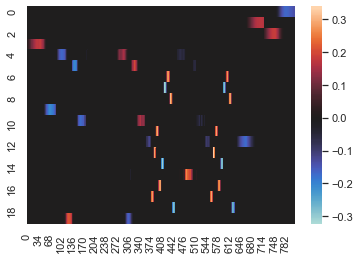

In [22]:
""" Dimensionality reduction using sparse PCA"""

from sklearn.decomposition import SparsePCA
pca = SparsePCA(n_components=20)
pca.fit(trials_matrix)
trials_matrix_pca = pca.transform(trials_matrix)
print(pca.components_.shape)

sb.heatmap(pca.components_, center=0)
plt.savefig(os.path.join(full_clustering_path, 'sparsepca_coeffs.png'))
plt.show()

In [23]:
# temp_df = pd.DataFrame(trials_matrix_pca)
# temp_df['labels'] = trial_mouselines #tm_ints*10
# sb.pairplot(temp_df, hue='labels', palette='tab10')
# plt.show()

In [24]:
""" Visualize high dimensional responses in 2 dimensions. """
import umap
reducer_umap = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='euclidean', n_components=5) # set low_memory=True
# embeddings_umap = reducer_umap.fit_transform(np.vstack([stim_heatmap, rand_heatmap]))
embeddings_umap = reducer_umap.fit_transform(trials_matrix_pca)
# fig, axs = plt.subplots(1, 1, figsize=(3, 3), sharex=True, sharey=True)

# axs.scatter(embeddings_umap[::1,0], embeddings_umap[::1,1], c=tm_ints, alpha=0.7, linewidth=0.2, edgecolors='k', s=50)

# axs.set_axis_off()
# axs.set(xticks=[], yticks=[])
# fig.tight_layout()
# plt.savefig(os.path.join(full_clustering_path, 'UMAP.png'))
# plt.show()

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


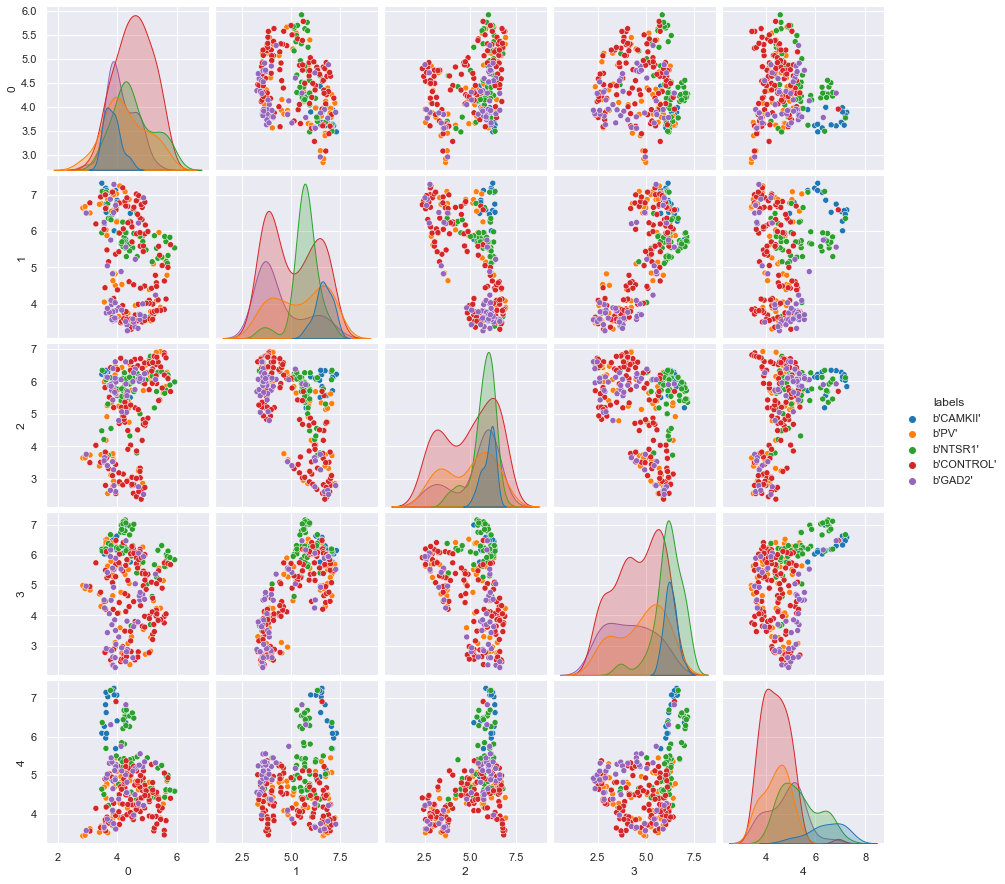

In [25]:
temp_df = pd.DataFrame(embeddings_umap)
temp_df['labels'] = trial_mouselines #tm_ints*10
sb.pairplot(temp_df, hue='labels', palette='tab10')
plt.savefig(os.path.join(full_clustering_path, 'umap_scattermatrix.png'))
plt.show()

In [26]:
""" Choose trials_matrix or trials_matrix_pca for clustering cluster"""
X = trials_matrix_pca
print(X.shape)

(267, 20)


In [27]:
# """ Run clustering analysis - KMedoids """
# analysis_results = []
# n_iters = 1
# for i in range(n_iters):
#     analysis_results.append(clustering.clustering.run_analysis_kmedoids(X, trial_mouselines, k_range=range(2,15), n_init=1000, metric='euclidean', max_iter=300))
# kmedoids_path = os.path.join(full_clustering_path, 'kmedoids')
# if not os.path.isdir(kmedoids_path):
#     os.mkdir(kmedoids_path)
    
# for crit, _ in analysis_results[0].items():
#     result = np.array([res[crit] for res in analysis_results])
#     sb.lineplot(x='variable', y='value', data=pd.DataFrame(result).melt(), ci='sd')
# #     plt.set(xticks=list(range(len(result))))
#     plt.xticks(list(range(result.shape[1])), np.array(list(range(result.shape[1])))+2)
#     plt.title(crit)
#     plt.savefig(os.path.join(kmedoids_path, f"{crit}.png"))
#     plt.show()

In [28]:
# """ Run clustering analysis - KMEANS """
# analysis_results = []
# n_iters = 1
# for i in range(n_iters):
#     analysis_results.append(clustering.clustering.run_analysis_kmeans(X, trial_mouselines, n_init=1000, k_range=range(2,15), max_iter=500))
# kmeans_path = os.path.join(full_clustering_path, 'kmeans')
# if not os.path.isdir(kmeans_path):
#     os.mkdir(kmeans_path)
    
# for crit, _ in analysis_results[0].items():
#     result = np.array([res[crit] for res in analysis_results])
#     sb.lineplot(x='variable', y='value', data=pd.DataFrame(result).melt(), ci='sd')
# #     plt.set(xticks=list(range(len(result))))
#     plt.xticks(list(range(result.shape[1])), np.array(list(range(result.shape[1])))+2)
#     plt.title(crit)
#     plt.savefig(os.path.join(kmeans_path, f"{crit}.png"))
#     plt.show()


100%|████████████████████████████████████████████| 13/13 [07:11<00:00, 33.23s/it]


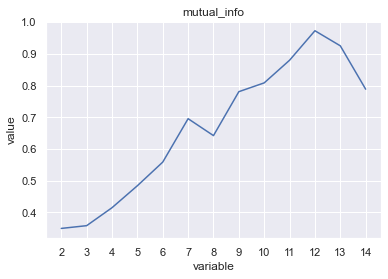

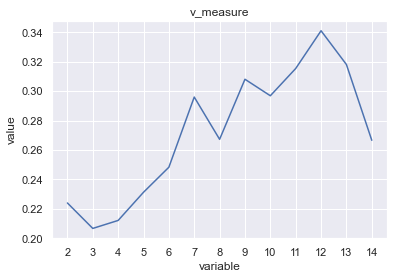

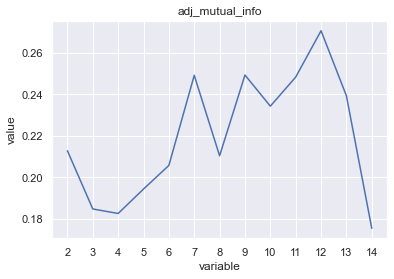

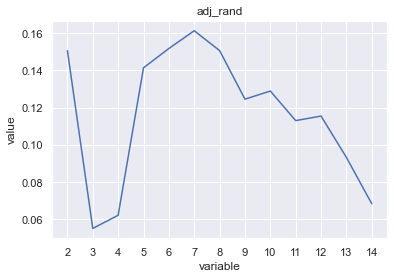

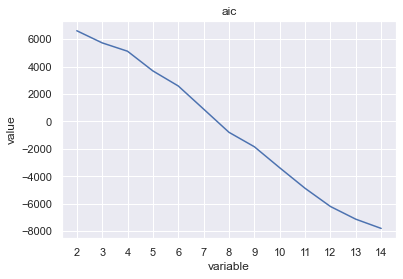

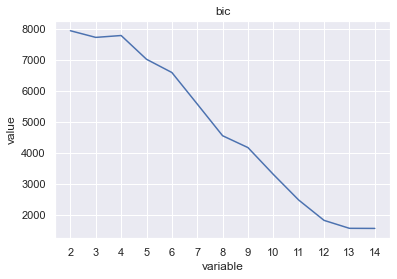

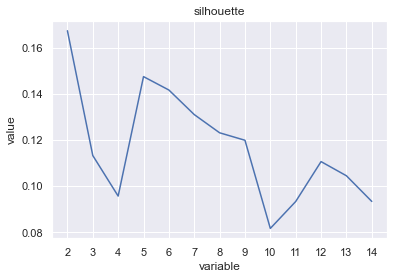

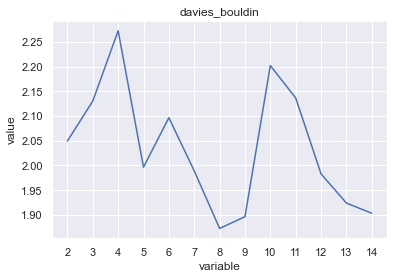

In [37]:
""" Run clustering analysis - GAUSSIAN MIXTURE """
analysis_results = []
n_iters = 1
analysis_results.append(clustering.clustering.run_analysis_gaussian_mixture(X[::2], trial_mouselines[::2], n_init=2000, k_range=range(2,15), max_iter=1000))
kmeans_path = os.path.join(full_clustering_path, 'gaussmixt')
if not os.path.isdir(kmeans_path):
    os.mkdir(kmeans_path)
    
for crit, _ in analysis_results[0].items():
    result = np.array([res[crit] for res in analysis_results])
    sb.lineplot(x='variable', y='value', data=pd.DataFrame(result).melt(), ci='sd')
    plt.xticks(list(range(result.shape[1])), np.array(list(range(result.shape[1])))+2)
    plt.title(crit)
    plt.savefig(os.path.join(kmeans_path, f"{crit}.png"))
    plt.show()

In [62]:
""" Run clustering on all trials. """
n_clusters = 8
algo = 'gaussmixt' # kmeans, gaussmixt
cluster_save_path = os.path.join(full_clustering_path, f'{algo}_{n_clusters}')
if not os.path.isdir(cluster_save_path):
    os.mkdir(cluster_save_path)
# kmeans = clustering.clustering.run_kmedoids(X, n_clusters, n_init=10000, metric='euclidean', max_iter=1000, init='heuristic') # Change algorithm!!
# kmeans = clustering.clustering.run_kmeans(X, n_clusters, n_init=1000, max_iter=1000) # Change algorithm!!
kmeans = clustering.clustering.run_gaussian_mixture(X, n_clusters, n_init=4000, max_iter=1000) # Change algorithm!!

# Create dict  with the predicted labels for each mouseline, experiment and session
df_dict_trials_clustered = {line: {} for line in trials_dict_flat.keys()}
for line, df_dict_line in trials_dict_flat.items():
    for (exp, sess), trials in df_dict_line.items():
        df_dict_trials_clustered[line][exp, sess] = kmeans.predict(pca.transform(trials))
#         df_dict_trials_clustered[line][exp, sess] = kmeans.predict(trials[:, useful_feats])

### Visualization

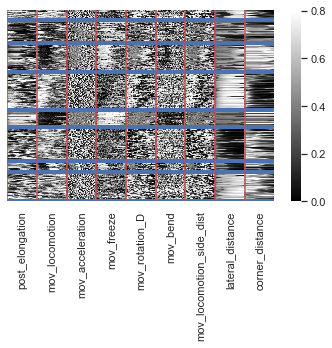

In [63]:
""" Clusters shown in heatmap. """
labels = kmeans.predict(X)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
heatmap_clusters = []
heatmap_mouselines = []
for cluster in range(n_clusters):
    heatmap_clusters.append(trials_matrix[labels==cluster])
    heatmap_mouselines.append(np.array(trial_mouselines)[labels==cluster])

combined_heatmap_clustered = np.vstack(heatmap_clusters)
sb.heatmap(combined_heatmap_clustered, cmap='gray', ax=ax) 
cluster_bounds = np.cumsum([len(heatmap_cluster) for heatmap_cluster in heatmap_clusters])
for bound in cluster_bounds:
    ax.axhline(bound, c='b', linewidth=4)

for i in range(len(clustering_measures)):
    ax.axvline(time_window*i, c='r')
ax.set_xticks(ticks=[time_window*i+(time_window//2) for i in range(len(clustering_measures))])
ax.set_xticklabels(labels=clustering_measures, rotation=90)
ax.set_yticks([])

plt.tight_layout()
plt.savefig(os.path.join(cluster_save_path, 'clustering_heatmap.png'), dpi=100)
plt.show()

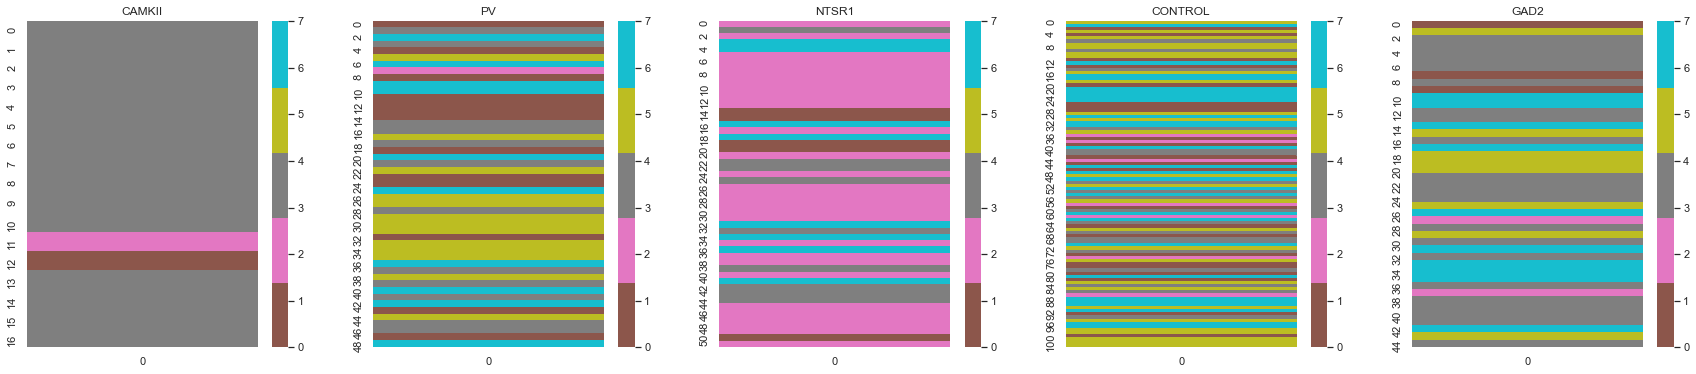

In [64]:
""" Clusters for each mouseline. """
df_dict_trials_clustered_flat, _ = flatten_dict_line(df_dict_trials_clustered)
fig, axs = plt.subplots(1, 5, figsize=(30, 6))
for i, (line, heatmap) in enumerate(df_dict_trials_clustered_flat.items()):
    sb.heatmap(np.expand_dims(heatmap, -1), ax=axs[i], center=0, vmin=0, vmax=n_clusters-1, cmap='tab10')
    axs[i].set_title(line)
plt.savefig(os.path.join(cluster_save_path, 'trial_labels.png'))
plt.show()

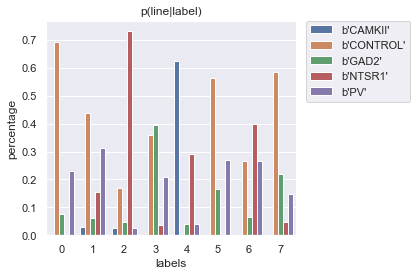

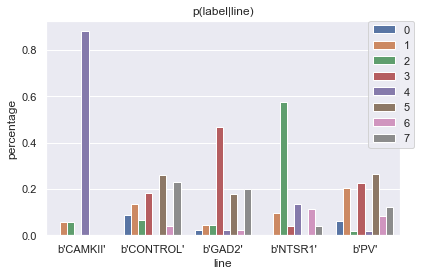

In [65]:
""" P(label|line) and P(line|label) distributions. """
temp = pd.DataFrame({'labels': labels, 'line': trial_mouselines})

percentages = (temp.groupby(['labels'])['line']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .reset_index()
                     .sort_values('line'))
sb.barplot(x="labels", y="percentage", hue="line", data=percentages)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.title("p(line|label)")
plt.tight_layout()
plt.savefig(os.path.join(cluster_save_path, 'P_line_label.png'), dpi=100)
plt.show()

# p(label|line)
fig, ax = plt.subplots(1, 1)
percentages = (temp.groupby(['line'])['labels']
                     .value_counts(normalize=100)
                     .rename('percentage')
                     .reset_index()
                     .sort_values('line'))
sb.barplot(x="line", y="percentage", hue="labels", data=percentages, ax=ax)
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
plt.title("p(label|line)")
plt.tight_layout()
plt.savefig(os.path.join(cluster_save_path, 'P_label_line.png'), dpi=100)
plt.show()

[[211 130 200]
 [196 192 186]
 [114  66  92]
 [212 197  62]
 [ 16   3  14]
 [167 149 216]
 [ 70 102  69]
 [158 257 179]]


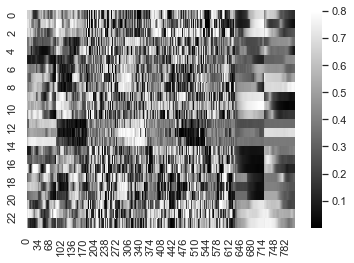

In [66]:
""" Create video for data closest to centroid of each cluster. """
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances
top = 3
# Find closest for each cluster
closest = pairwise_distances(kmeans.means_, Y=X, metric='euclidean').argsort(axis=1)[:,:top]
# closest = pairwise_distances(kmeans.cluster_centers_, Y=X, metric='euclidean').argsort(axis=1)[:,:top]

print(closest)
sb.heatmap(trials_matrix[closest.flatten()], cmap='gray')
plt.show()

In [67]:
import videoplayer.videowriter
import videoplayer.trial_viewer
# For each item in closest:
for i, cls in enumerate(closest):
    # Find line, exp, sess and trial in which it occurs
    writer = videoplayer.videowriter.VideoWriter(os.path.join(cluster_save_path, f'cluster{i}.avi'))
    for line, sess_data in trials_matrix_meta.items():
        for (exp, sess), (start_idx, stop_idx) in sess_data.items():     
            for cl in cls:
                if cl >= start_idx and cl < stop_idx:
                    # Create video for trial
                    trial_idx = cl - start_idx
                    try:
                        data_dlc, stim_times = dataset.get_session_dlc(line, exp, sess, 20)
                        video_path = dataset.get_video_path(line, exp, sess)
                        start_trial, stop_trial = stim_times[trial_idx][0], stim_times[trial_idx][1]
                        writer.add_trial(data_dlc, video_path, start_trial, start_trial+5*30)
                    except Exception as e:
                        print(e)
    try:
        writer.write()
    except IndexError as e:
        print(e)

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
14860 15010


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
6451 6601


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
14194 14344


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
27640 27790


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
22652 22802


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
18092 18242


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
5440 5590


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
14637 14787


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
20031 20181


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
7984 8134


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
23810 23960


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
15413 15563


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
17113 17263


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
12886 13036


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
7340 7490


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
11266 11416


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
25662 25812


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
11146 11296


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
15510 15660


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
11437 11587


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
16098 16248


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
10881 11031


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
16066 16216


c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\pandas\core\generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


['ear_left', 'ear_right', 'nose', 'tail_end', 'tail_start']
14745 14895
